# Introduction of Deep Learning for Computer Vision 
### Computer Vision and Machine Learning Research Group, Shenzhen University, 2019 Dec.

Network Structure: AlexNet  
Dataset: cifar-10 or ImageNet  
Instructor: Yan Yan  
Email: yyan@szu.edu.cn

Referece: ImageNet Classification with Deep Convolutional Neural, Alex Krizhevsky, Sutskever, Ilya, Hinton, Geoffrey E, Advances in Neural Information Processing Systems 25, pp.1097--1105, 2012
[Download Link](
http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)  

Code is mostly based on:  
https://www.cnblogs.com/zhengbiqing/p/10425503.html  contact：zhengbiqing 460356155@qq.com  
and  
https://blog.csdn.net/yychentracy/article/details/90256033  
and  
https://github.com/sloth2012/AlexNet/blob/master/AlexNet.ipynb
  
Dataset can be downloaded from:
http://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import torch as t
import torchvision as tv
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torch.backends.cudnn as cudnn

import datetime
import argparse


# 样本读取线程数
WORKERS = 4

# 网络参赛保存文件名
PARAS_FN = 'cifar_lenet_params.pkl'

# minist数据存放位置
ROOT = '/home/szu-admin/local/data/cifar-10-100/cifar.10.py'

# 目标函数
loss_func = nn.CrossEntropyLoss()

# 最优结果
best_acc = 0

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.cnn = nn.Sequential(
            # 卷积层1，3通道输入，96个卷积核，核大小7*7，步长2，填充2
            # 经过该层图像大小变为32-7+2*2 / 2 +1，15*15
            # 经3*3最大池化，2步长，图像变为15-3 / 2 + 1， 7*7
            nn.Conv2d(3, 96, 7, 2, 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 0),

            # 卷积层2，96输入通道，256个卷积核，核大小5*5，步长1，填充2
            # 经过该层图像变为7-5+2*2 / 1 + 1，7*7
            # 经3*3最大池化，2步长，图像变为7-3 / 2 + 1， 3*3
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 0),

            # 卷积层3，256输入通道，384个卷积核，核大小3*3，步长1，填充1
            # 经过该层图像变为3-3+2*1 / 1 + 1，3*3
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(inplace=True),

            # 卷积层3，384输入通道，384个卷积核，核大小3*3，步长1，填充1
            # 经过该层图像变为3-3+2*1 / 1 + 1，3*3
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(inplace=True),

            # 卷积层3，384输入通道，256个卷积核，核大小3*3，步长1，填充1
            # 经过该层图像变为3-3+2*1 / 1 + 1，3*3
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(inplace=True)
        )

        self.fc = nn.Sequential(
            # 256个feature，每个feature 3*3
            nn.Linear(256*3*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.cnn(x)

        # x.size()[0]: batch size
        x = x.view(x.size()[0], -1)
        x = self.fc(x)

        return x

    
'''
训练并测试网络
net：网络模型
train_data_load：训练数据集
optimizer：优化器
epoch：第几次训练迭代
log_interval：训练过程中损失函数值和准确率的打印频率
'''
def net_train(net, train_data_load, optimizer, epoch, log_interval):
    net.train()

    begin = datetime.datetime.now()

    # 样本总数
    total = len(train_data_load.dataset)

    # 样本批次训练的损失函数值的和
    train_loss = 0

    # 识别正确的样本数
    ok = 0

    for i, data in enumerate(train_data_load, 0):
        img, label = data
        img, label = img.cuda(), label.cuda()

        optimizer.zero_grad()

        outs = net(img)
        loss = loss_func(outs, label)
        loss.backward()
        optimizer.step()

        # 累加损失值和训练样本数
        train_loss += loss.item()
        # total += label.size(0)

        _, predicted = t.max(outs.data, 1)
        # 累加识别正确的样本数
        ok += (predicted == label).sum()

        if (i + 1) % log_interval == 0:
            # 训练结果输出

            # 损失函数均值
            loss_mean = train_loss / (i + 1)

            # 已训练的样本数
            traind_total = (i + 1) * len(label)

            # 准确度
            acc = 100. * ok / traind_total

            # 一个迭代的进度百分比
            progress = 100. * traind_total / total

            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}  Acc: {:.6f}'.format(
                epoch, traind_total, total, progress, loss_mean, acc))

    end = datetime.datetime.now()
    print('one epoch spend: ', end - begin)


'''
用测试集检查准确率
'''
def net_test(net, test_data_load, epoch):
    net.eval()

    ok = 0

    for i, data in enumerate(test_data_load):
        img, label = data
        img, label = img.cuda(), label.cuda()

        outs = net(img)
        _, pre = t.max(outs.data, 1)
        ok += (pre == label).sum()

    acc = ok.item() * 100. / (len(test_data_load.dataset))
    print('EPOCH:{}, ACC:{}\n'.format(epoch, acc))

    global best_acc
    if acc > best_acc:
        best_acc = acc


'''
显示数据集中一个图片
'''
def img_show(dataset, index):
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    show = ToPILImage()

    data, label = dataset[index]
    print('img is a ', classes[label])
    show((data + 1) / 2).resize((100, 100)).show()

In [2]:
#parser = argparse.ArgumentParser(description='PyTorch CIFA10 LeNet Example')

In [23]:
# 训练超参数设置，可通过命令行设置
bs = 64            # batch-size
testbs = 1000      # test-batch-size
ep = 20            # epochs 
trainlr = 0.01     # learning rate (default: 0.01)
mm = 0.9           # SGD momentum (default: 0.9)
logint = 100       # log-interval
notrain = False    # If train the Model
savemodel = False  # For Saving the current Model

In [11]:
# 图像数值转换，ToTensor源码注释
"""
Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
Converts a PIL Image or numpy.ndarray (H x W x C) in the range
[0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
"""
# 归一化把[0.0, 1.0]变换为[-1,1], ([0, 1] - 0.5) / 0.5 = [-1, 1]
transform = tv.transforms.Compose([
transforms.ToTensor(),
transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# 定义数据集
#train_data = tv.datasets.CIFAR10(root=ROOT, train=True, download=True, transform=transform)
train_data = tv.datasets.CIFAR10(root=ROOT, train=True, download=False, transform=transform)
test_data = tv.datasets.CIFAR10(root=ROOT, train=False, download=False, transform=transform)

train_load = t.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=WORKERS)
test_load = t.utils.data.DataLoader(test_data, batch_size=testbs, shuffle=False, num_workers=WORKERS)

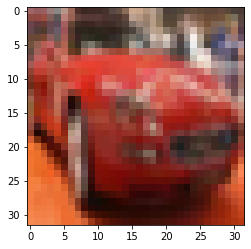

In [43]:
# 看一下数据中的等待分类的图片
from PIL import Image
import sys
#im = Image.open(train_data.data[5][0])
im = Image.fromarray(train_data.data[5][:])
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(im)

In [12]:
# define AlexNet
net = AlexNet().cuda()
# print network structure
print(net)

AlexNet(
  (cnn): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [25]:
# 如果不训练，直接加载保存的网络参数进行测试集验证
if notrain:
    net.load_state_dict(t.load(PARAS_FN))
    net_test(net, test_load, 0)

else:
    optimizer = optim.SGD(net.parameters(), lr=trainlr, momentum=mm)

    start_time = datetime.datetime.now()

    for epoch in range(1, ep + 1):
        net_train(net, train_load, optimizer, epoch, logint)

        # 每个epoch结束后用测试集检查识别准确度
        net_test(net, test_load, epoch)

        end_time = datetime.datetime.now()

    global best_acc
    #print('CIFAR10 pytorch LeNet Train: EPOCH:{}, BATCH_SZ:{}, LR:{}, ACC:{}'.format(args.epochs, args.batch_size, lr, best_acc))
    print('CIFAR10 pytorch AlexNet Train: EPOCH:{}, BATCH_SZ:{}, LR:{}, ACC:{}'.format(ep, bs, trainlr, best_acc))
    print('train spend time: ', end_time - start_time)

    if savemodel:
        t.save(net.state_dict(), PARAS_FN)

Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.050328  Acc: 98.000000
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.054780  Acc: 98.000000
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.061450  Acc: 97.000000
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.059535  Acc: 97.000000
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.060373  Acc: 97.000000
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.068226  Acc: 97.000000
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.067621  Acc: 97.000000
one epoch spend:  0:00:05.983943
EPOCH:1, ACC:75.66

Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.038682  Acc: 98.000000
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.038624  Acc: 98.000000
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.040471  Acc: 98.000000
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.045076  Acc: 98.000000
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.048262  Acc: 98.000000
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.048755  Acc: 98.000000
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.050158  Acc: 98.000000
one epoch spend:  0:00:05